In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [2]:
crop = pd.read_csv("Crop_recommendation.csv")

In [3]:
crop.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
crop.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [6]:
crop.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

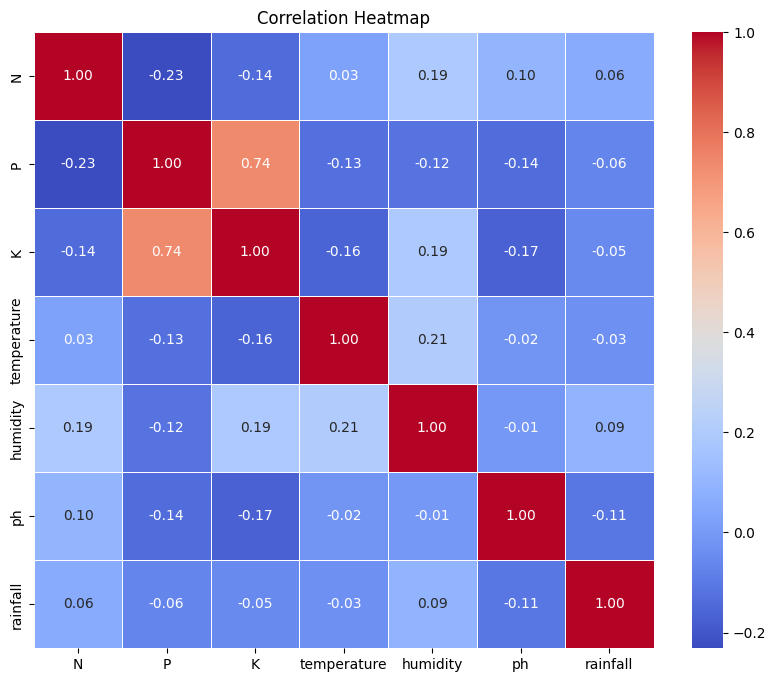

In [7]:
# Correlation matrix
cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
correlation_matrix = crop[cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9344\4043190485.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="label", data=crop, order=crop['label'].value_counts().index, palette="viridis")


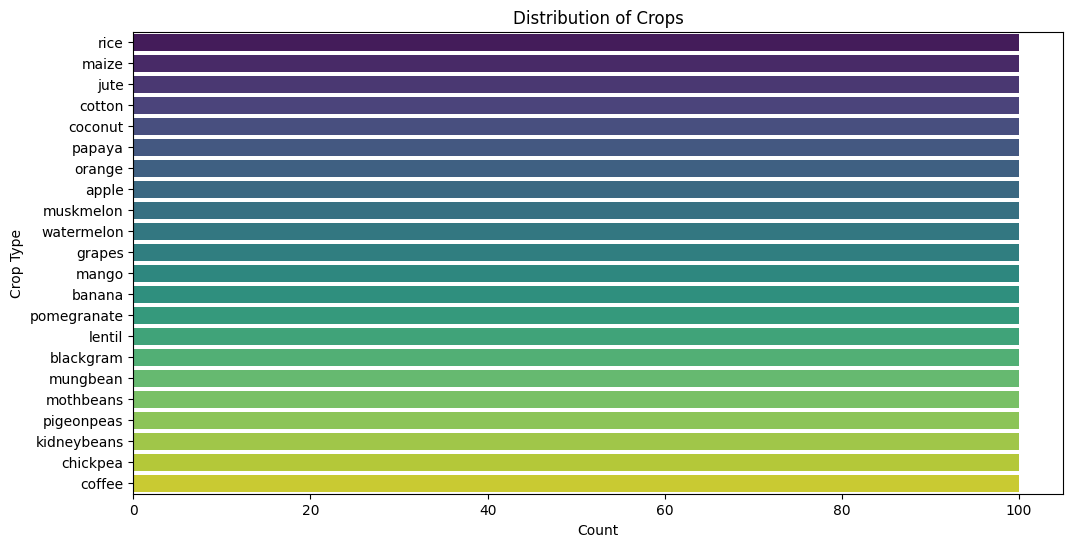

In [8]:
# Distribution of the target variable
plt.figure(figsize=(12, 6))
sns.countplot(y="label", data=crop, order=crop['label'].value_counts().index, palette="viridis")
plt.title("Distribution of Crops")
plt.xlabel("Count")
plt.ylabel("Crop Type")
plt.show()

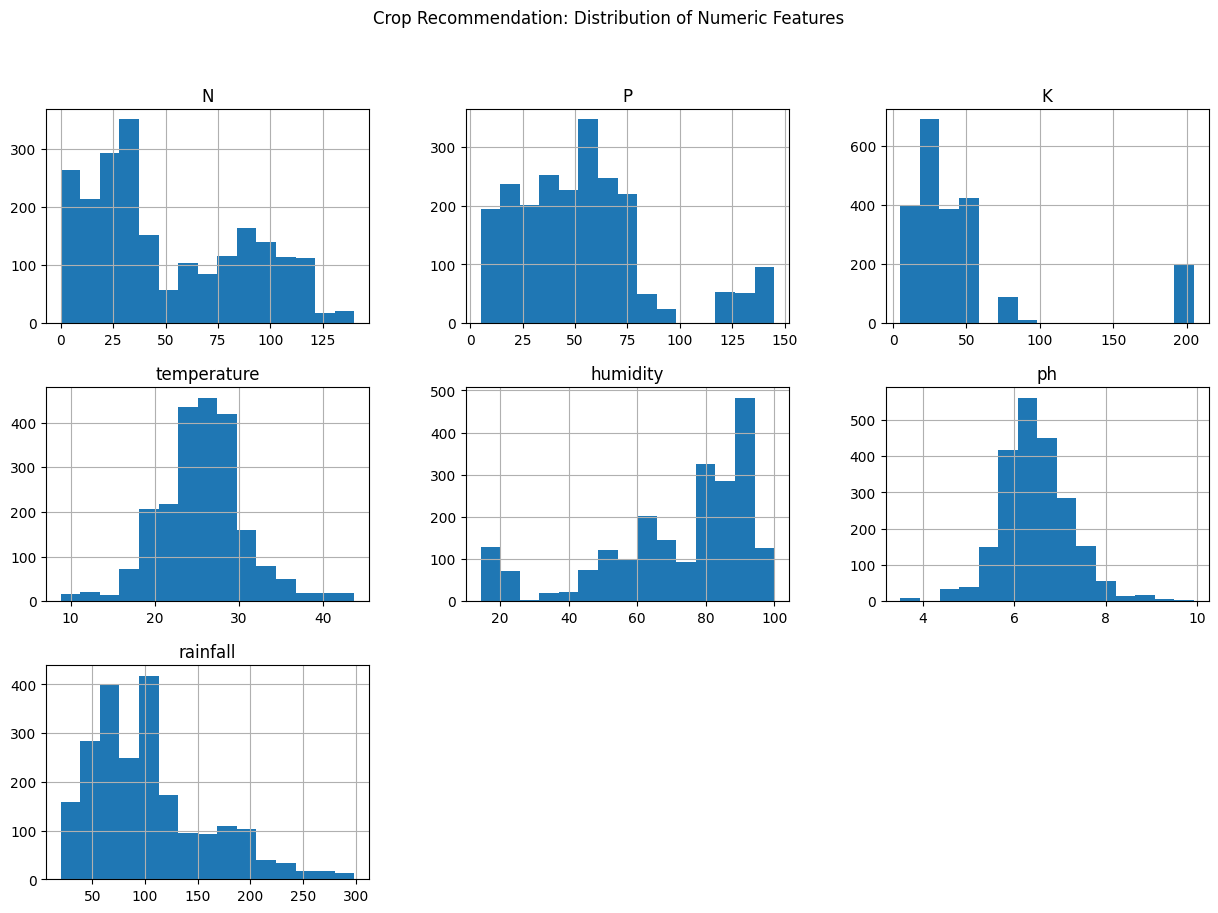

In [9]:
# Distribution of numerical features

crop[cols].hist(bins=15, figsize=(15, 10))
plt.suptitle('Crop Recommendation: Distribution of Numeric Features')
plt.show()

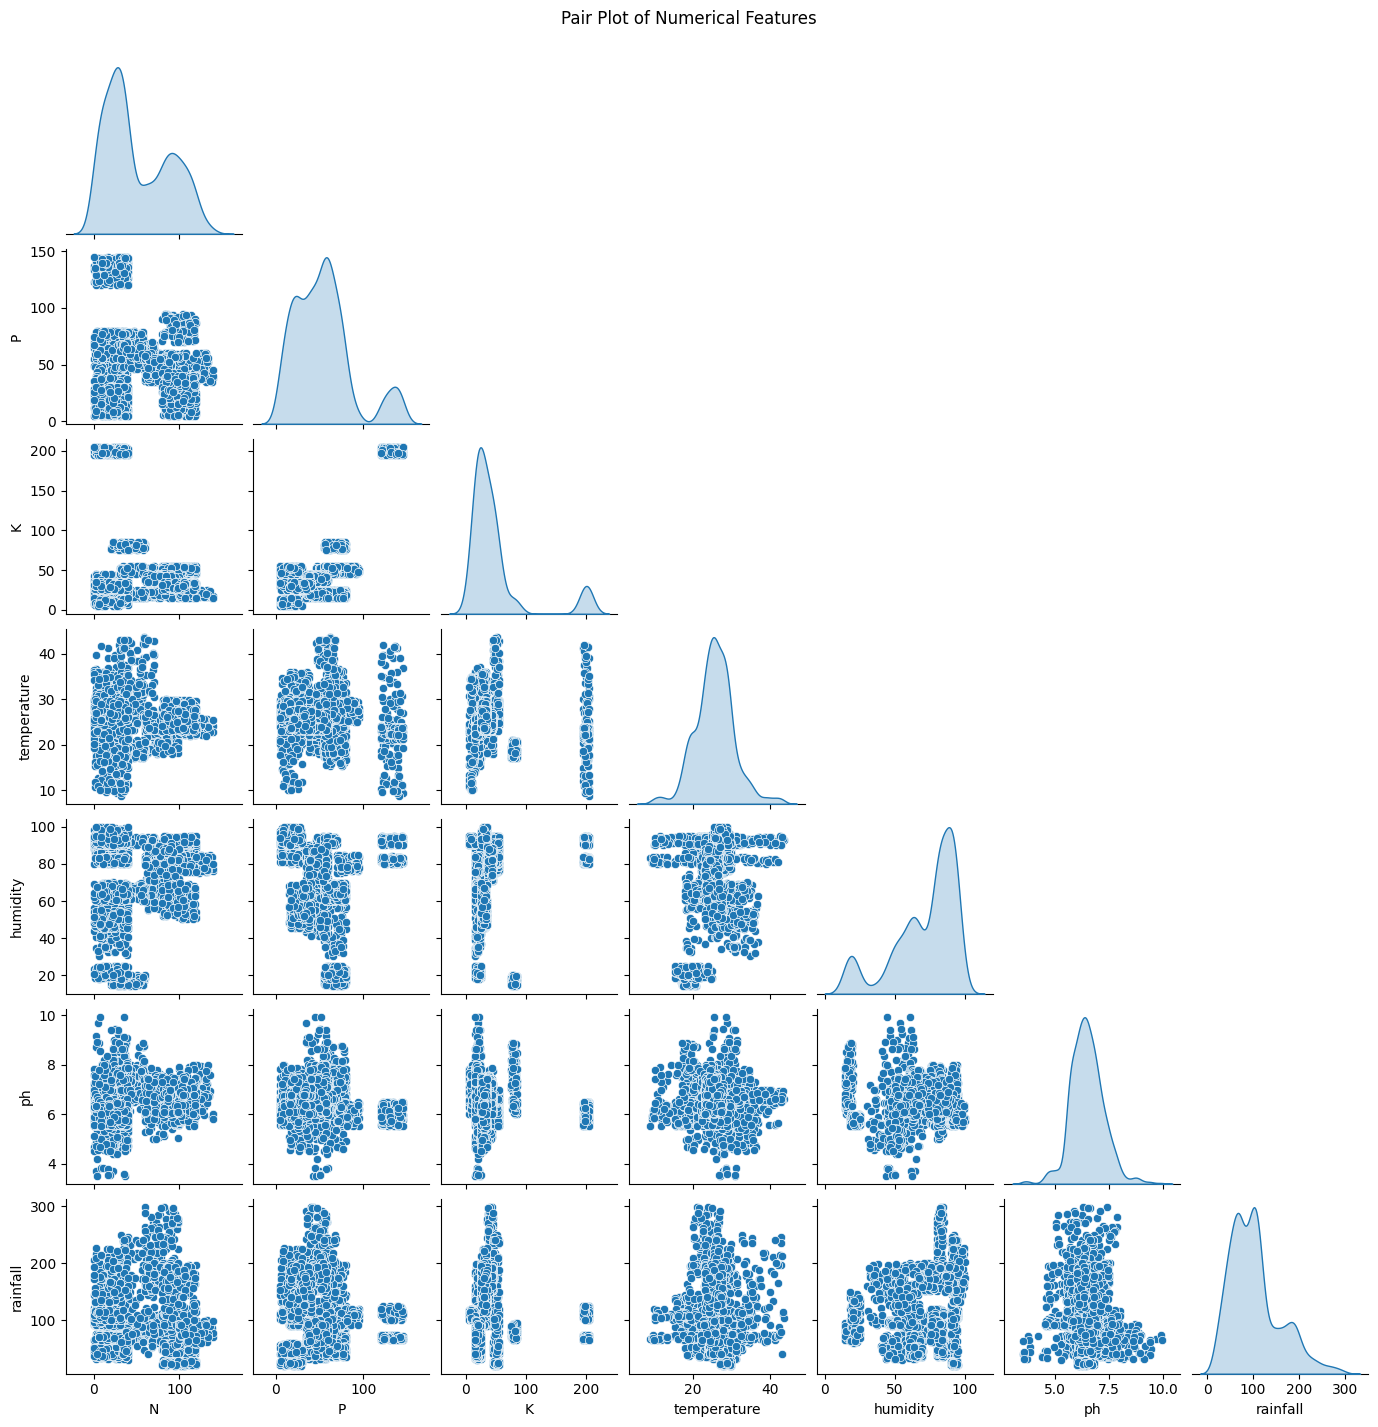

In [10]:
# Pair plot for numerical features
numeric_columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

sns.pairplot(crop[numeric_columns], diag_kind="kde", corner=True, height=2)
plt.suptitle("Pair Plot of Numerical Features", y=1.02)
plt.show()

In [11]:
# Convert numeric columns to proper numeric types and handle errors
for col in numeric_columns:
    crop[col] = pd.to_numeric(crop[col], errors='coerce')

# Remove rows with invalid values in numeric columns
invalid_rows = crop[numeric_columns].isnull().any(axis=1)
cleaned_crop = crop[~invalid_rows]

# Check cleaned data
print("Cleaned Data Info:")
print(cleaned_crop.info())

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None


In [12]:
X = crop.drop("label", axis = 1)
y = crop["label"]

y = y.astype('category')
mapping = dict(enumerate(y.cat.categories))

y = y.cat.codes

# Display the unique encoded labels and the mapping
print("\nMapping of Encoded Values to Original Labels:")
for code, label in mapping.items():
    print(f"{code}: {label}")


Mapping of Encoded Values to Original Labels:
0: apple
1: banana
2: blackgram
3: chickpea
4: coconut
5: coffee
6: cotton
7: grapes
8: jute
9: kidneybeans
10: lentil
11: maize
12: mango
13: mothbeans
14: mungbean
15: muskmelon
16: orange
17: papaya
18: pigeonpeas
19: pomegranate
20: rice
21: watermelon


In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2347)

In [14]:
from sklearn import config_context

In [15]:
with config_context(display="text"):
    model = xgb.XGBClassifier(
        objective="multi:softmax",
        num_class=len(np.unique(y)),
        learning_rate=0.01,
        max_depth=6,
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)

In [16]:
y_pred = model.predict(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy is: {accuracy * 100:.2f}%")

Accuracy is: 98.86%


In [18]:
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy is: {accuracy * 100 :.2f}%")
print()
print("Confusion Matrix is:\n", cm)
print()
print("Classification Report is : \n" , report)

Accuracy is: 98.86%

Confusion Matrix is:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 21  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  

In [19]:
def crop_rec(N, P, K, temp, hum, ph, rain):
    features = np.array([[N, P, K, temp, hum, ph, rain]])
    prediction = model.predict(features).reshape(-1)  # Ensure it's a 1D array
    crop_dict = {0: 'apple',
                1: 'banana',
                2: 'blackgram',
                3: 'chickpea',
                4: 'coconut',
                5: 'coffee',
                6: 'cotton',
                7: 'grapes',
                8: 'jute',
                9: 'kidneybeans',
                10: 'lentil',
                11: 'maize',
                12: 'mango',
                13: 'mothbeans',
                14: 'mungbean',
                15: 'muskmelon',
                16: 'orange',
                17: 'papaya',
                18: 'pigeonpeas',
                19: 'pomegranate',
                20: 'rice',
                21: 'watermelon'}
    predicted_crop = crop_dict[prediction[0]]  # Take only the first value
    return f"{predicted_crop} is the best crop to grow in the farm."

In [20]:
N = 90
P = 45
K= 43
temp = 20
hum = 82
ph = 6.1
rain = 202

crop_rec(N, P, K, temp, hum, ph, rain)

'rice is the best crop to grow in the farm.'

In [24]:
import pickle

# Save the model
with open("Crop_recommendation.pkl", "wb") as f:
    pickle.dump(model, f)

# Load it later
with open("Crop_recommendation.pkl", "rb") as f:
    model = pickle.load(f)